***EXPERIMENT SETUP***

- percentages_set_1 = [0.01, 0.03, 0.05, 0.1, 0.15, 0.2, 0.4, 0.6, 0.8, 1]
- dataset: same as before MNIST 5 to 5

- lr pretraining = 0.01
- lr finetuning = 0.001

- architecture:
    - Conv 1 (5,5), channels=1
    - Relu
    - Conv 2 (5,5,), channels=1
    - Relu
    - Pooling: False
    - dense( x, x) x=output shape of prev layer (128?)
    - Relu
    - dense(x, 5)
    - softmax
    
- Freezing: NO

- Reinitializing CNN layers: No
- Reinitializing CNN layers: Both
- Reinitializing softmax layers: Yes

- If we don’t save the best model, ES=6

- num train = 20

***IMPORTS***

In [17]:
import numpy as np
import random
import copy
import matplotlib.pyplot as plt
import json
from tqdm.auto import tqdm

In [18]:
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from torchvision import datasets, transforms

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from types import SimpleNamespace

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

***UTILS***

In [20]:
def eval(model, device, dataset_loader, debug=False, classification_report_flag=False, is_cnn=True, logger=print):

    """
    Evaluates the model on the given dataset loader.

    Parameters:
    - model: the PyTorch model to evaluate.
    - device: the device to which tensors should be moved before computation.
    - dataset_loader: DataLoader for evaluation.
    - debug: whether to print debug info like loss and accuracy.
    - classification_report_flag: whether to print a classification report.
    - is_cnn: a flag indicating if the model is a CNN. If it's not, the input data will be reshaped.
    - logger: logging function for printing messages.

    Returns:
    - Accuracy of the model on the provided dataset loader.

    Usage:
    - accuracy = eval(model, device, dataset_loader, debug=False, is_cnn=False, classification_report_flag=False)
    """

    model.eval()
    test_loss, correct = 0., 0.
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data, target in dataset_loader:
            if is_cnn:
              data = data.view(data.size(0), 1, 28, 28)
            else:
              data = data.reshape([data.shape[0], -1])
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(target.cpu().numpy())

    num_data = len(dataset_loader.dataset)
    test_loss /= num_data
    acc = correct / num_data

    if debug:
        logger('\nAverage loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss, correct, num_data, 100. * acc))

    if classification_report_flag:
        unique_labels = np.unique(all_labels).tolist()
        logger(classification_report(all_labels, all_preds, labels=unique_labels, target_names=[f'Class {i}' for i in unique_labels]))

    return acc

In [21]:
class Trainer:

    """
    A class for training and evaluating a model with early stopping and best model saving functionalities.

    Attributes:
    - model: PyTorch model to be trained and evaluated.
    - dataloader: Contains data loaders (train, validation, test) for training and evaluation.
    - params: Dictionary containing various hyperparameters and settings.
    - device: the device to which tensors should be moved before computation.
    - optimizer: The optimizer for training.
    - best_model_state: State dictionary of the best model.
    - max_val_acc: The highest validation accuracy encountered during training.
    - no_improve_epochs: Number of epochs without improvement in validation accuracy.
    - is_cnn: Flag indicating if the model is a CNN.
    - is_debug: Flag indicating if debug information should be printed.
    - classification_report_flag: Flag indicating if a classification report should be generated.

    Methods:
    - train_epoch(): Runs a single epoch of training.
    - evaluate(loader): Evaluates the model on a given data loader.
    - save_best_model(): Saves the current state of the model as the best model.
    - save_checkpoint(epoch, train_acc, val_acc): Saves the current state of the model and other information as a checkpoint.
    - early_stopping_check(val_acc): Checks the stopping criterion and performs actions based on it.
    - train(): Runs the training process for a number of epochs, with early stopping functionality.

    Usage:
    params = {
      'device': 'cuda',
      'lr': 0.001,
      'num_train': 10,
      'early_stop_patience': 3,
      'save_best': True,
      'save_checkpoints': False,
      'is_cnn': True,
      'is_debug': True,
      'classification_report_flag': True
    }

    trainer = Trainer(model, dataloader, params)
    train_acc, test_acc, effective_epochs, checkpoints = trainer.train()
    """


    def __init__(self, model, dataloader, params):
        self.model = model
        self.dataloader = dataloader
        self.params = params

        self.device = torch.device(params['device'])
        self.optimizer = optim.Adam(model.parameters(), lr=params['lr'])

        # Initialize best_model_state with the current model state
        self.best_model_state = copy.deepcopy(self.model.state_dict())
        self.max_val_acc = 0.
        self.no_improve_epochs = 0

        self.is_cnn = params.get('is_cnn', False)
        self.is_debug = params.get('is_debug', False)
        self.classification_report_flag = params.get('classification_report_flag', False)
        self.logger = params.get('logger', print)
        
    def train_epoch(self):
      self.model.train()
      for batch_idx, (data, target) in enumerate(self.dataloader.train_loader):

          # Print the size of the current batch
          if self.is_cnn:
            data = data.view(data.size(0), 1, 28, 28)
          else:
            data = data.reshape([data.shape[0], -1])

          data, target = data.to(self.device), target.to(self.device)
          self.optimizer.zero_grad()
          output = self.model(data)
          loss = F.nll_loss(output, target)
          loss.backward()
          self.optimizer.step()

          if self.is_debug and batch_idx % 20 == 0:
              self.logger(f"Batch: {batch_idx}, Loss: {loss.item()}")

    def evaluate(self, loader):
        return eval(self.model, self.device, loader, self.is_debug, self.classification_report_flag, self.is_cnn)

    def save_best_model(self):
        torch.save(self.model.state_dict(), 'best_model.pth')

    def save_checkpoint(self, epoch, train_acc, val_acc):
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'train_acc': train_acc,
            'val_acc': val_acc
        }
        torch.save(checkpoint, f'checkpoint_epoch_{epoch}.pth')
        return checkpoint

    def early_stopping_check(self, val_acc):
        if val_acc > self.max_val_acc:
            self.max_val_acc = val_acc
            self.no_improve_epochs = 0
            # Deep copy the model's state
            self.best_model_state = copy.deepcopy(self.model.state_dict())
            if self.params.get('save_best', False):
                self.save_best_model()
        else:
            self.no_improve_epochs += 1
            if self.no_improve_epochs >= self.params['early_stop_patience']:
                self.logger("Early stopping invoked.")
                # Only load if best_model_state has been set
                if self.best_model_state is not None:
                    self.model.load_state_dict(self.best_model_state)
                return True
        return False

    def train(self):
        effective_epochs = 0
        checkpoints = []

        for epoch in range(self.params['num_train']):
            effective_epochs += 1
            self.train_epoch()

            train_acc = self.evaluate(self.dataloader.train_loader)
            val_acc = self.evaluate(self.dataloader.val_loader)
            self.logger(f'Epoch: {epoch} \tTraining Accuracy: {train_acc*100:.2f}%')
            self.logger(f'Validation Accuracy: {val_acc*100:.2f}%')

            if self.params.get('early_stop_patience', None):
                if self.early_stopping_check(val_acc):
                    self.model.load_state_dict(self.best_model_state)
                    break

            if self.params.get('save_checkpoints', False):
                checkpoint = self.save_checkpoint(epoch, train_acc, val_acc)
                checkpoints.append(checkpoint)

        # Final evaluations
        train_acc = self.evaluate(self.dataloader.train_loader)
        test_acc = self.evaluate(self.dataloader.test_loader)

        return train_acc, test_acc, effective_epochs, checkpoints

In [22]:
def reduce_dataset(dataloader, percentage, balanced=True, seed=42):

    """
    Reduces the dataset to the given percentage. Can ensure class balance if needed.

    Parameters:
    - dataloader: PyTorch DataLoader object.
    - percentage: Desired percentage of the original dataset.
    - balanced: If True, ensures class balance. If False, reduces randomly.
    - seed: Seed for reproducibility.

    Returns:
    - reduced_dataloader: DataLoader with the reduced dataset.
    """
    # Extract the dataset from the dataloader
    dataset = dataloader.dataset

    # Extract all data and labels from the dataset
    X = [dataset[i][0] for i in range(len(dataset))]
    y = [dataset[i][1] for i in range(len(dataset))]

    # Set the seed for reproducibility
    torch.manual_seed(seed)

    if not balanced:
        # Determine the number of samples to keep
        num_samples = int(len(dataset) * percentage)

        # Randomly select indices without replacement
        indices = torch.randperm(len(dataset))[:num_samples].tolist()

    else:
        # Get unique classes and their counts
        classes, class_counts = torch.unique(torch.tensor(y), return_counts=True)

        # Determine the number of samples per class to keep
        num_samples_per_class = int(len(dataset) * percentage / len(classes))
        indices = []

        for class_label in classes:
            class_indices = [i for i, label in enumerate(y) if label == class_label]

            # Randomly select indices without replacement for each class
            class_selected_indices = torch.randperm(len(class_indices))[:num_samples_per_class].tolist()
            indices.extend([class_indices[i] for i in class_selected_indices])

    # Use a Subset of the original dataset to create a reduced dataset
    reduced_dataset = data.Subset(dataset, indices)

    # Create a DataLoader with the reduced dataset.
    reduced_dataloader = data.DataLoader(reduced_dataset, batch_size=dataloader.batch_size, shuffle=True)

    return reduced_dataloader

In [23]:
class RelabeledSubset(torch.utils.data.Dataset):
    def __init__(self, dataset, offset):
        self.dataset = dataset
        self.offset = offset

    def __getitem__(self, idx):
        data, label = self.dataset[idx]
        # Offset the label to start from 0
        label = label - self.offset
        return data, label

    def __len__(self):
        return len(self.dataset)

In [24]:
class TransferLearningMNIST(object):
    def __init__(self, batch_size, input_dim=28*28, val_split=0.1, num_workers=4):
        self.input_dim = input_dim
        self.output_dim = 10
        self.val_split = val_split

        def filter_dataset(dataset, classes):
            indices = [i for i, t in enumerate(dataset.targets) if t in classes]
            return torch.utils.data.Subset(dataset, indices)

        mnist_train_data = datasets.MNIST(
            '../data',
            train=True,
            download=True,
            transform=transforms.Compose([
                transforms.ToTensor(),
                transforms.Lambda(lambda x: (x * 2 - 1) * 0.5),
            ]))

        pretrain_train_data = filter_dataset(mnist_train_data, list(range(5)))
        finetune_train_data = filter_dataset(mnist_train_data, list(range(5, 10)))

        pretrain_len = len(pretrain_train_data)
        finetune_len = len(finetune_train_data)
        pretrain_val_len = int(val_split * pretrain_len)
        finetune_val_len = int(val_split * finetune_len)
        SEED = 42
        pretrain_train_set, pretrain_val_set = torch.utils.data.random_split(
            pretrain_train_data, [pretrain_len - pretrain_val_len, pretrain_val_len], generator=torch.Generator().manual_seed(SEED))
        finetune_train_set, finetune_val_set = torch.utils.data.random_split(
            finetune_train_data, [finetune_len - finetune_val_len, finetune_val_len], generator=torch.Generator().manual_seed(SEED))

        self.pretrain_train_loader = torch.utils.data.DataLoader(pretrain_train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)
        self.pretrain_val_loader = torch.utils.data.DataLoader(pretrain_val_set, batch_size=batch_size, shuffle=False, num_workers=num_workers)
        
        # Use the RelabeledSubset for fine-tuning datasets
        finetune_train_set = RelabeledSubset(finetune_train_set, 5)
        finetune_val_set = RelabeledSubset(finetune_val_set, 5)

        self.finetune_train_loader = torch.utils.data.DataLoader(finetune_train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)
        self.finetune_val_loader = torch.utils.data.DataLoader(finetune_val_set, batch_size=batch_size, shuffle=False, num_workers=num_workers)

        mnist_test_data = datasets.MNIST(
            '../data',
            train=False,
            download=True,
            transform=transforms.Compose([
                transforms.ToTensor(),
                transforms.Lambda(lambda x: (x * 2 - 1) * 0.5),
            ]))

        pretrain_test_data = filter_dataset(mnist_test_data, list(range(5)))
        finetune_test_data = filter_dataset(mnist_test_data, list(range(5, 10)))

        self.pretrain_test_loader = torch.utils.data.DataLoader(pretrain_test_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)
        
        # Use the RelabeledSubset for fine-tuning test datasets
        finetune_test_data = RelabeledSubset(finetune_test_data, 5)
        self.finetune_test_loader = torch.utils.data.DataLoader(finetune_test_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)

        # Complete test loader contains all test examples.
        self.complete_test_loader = torch.utils.data.DataLoader(mnist_test_data, batch_size=batch_size, shuffle=False, num_workers=num_workers)

In [25]:
class TransferLearningMNISTWrapper:
    """
    This wrapper class provides a convenient way to switch between pretraining and fine-tuning phases.

    It allows for changing the phase and accordingly updating the data loaders (train, val, test)
    to either pretraining or fine-tuning sets.
    """
    def __init__(self, transferLearningMNISTObj, phase):
        """
        Initializes the TransferLearningMNISTWrapper object.

        Parameters:
        - transferLearningMNISTObj: An instance of the TransferLearningMNIST class.
        - phase: String indicating the current phase ("pretrain" or "finetune").
        """
        self.transferLearningMNISTObj = transferLearningMNISTObj
        self.phase = phase
        self.input_dim = self.transferLearningMNISTObj.input_dim
        self.output_dim = self.transferLearningMNISTObj.output_dim
        self.update_phase(phase)

    def update_phase(self, phase):
        """
        Updates the phase and the corresponding data loaders.

        Parameters:
        - phase: String indicating the desired phase ("pretrain" or "finetune").

        Throws:
        - ValueError: If the phase is neither "pretrain" nor "finetune".
        """
        self.phase = phase
        if phase == 'pretrain':
            self.train_loader = self.transferLearningMNISTObj.pretrain_train_loader
            self.val_loader = self.transferLearningMNISTObj.pretrain_val_loader
            self.test_loader = self.transferLearningMNISTObj.pretrain_test_loader
        elif phase == 'finetune':
            self.train_loader = self.transferLearningMNISTObj.finetune_train_loader
            self.val_loader = self.transferLearningMNISTObj.finetune_val_loader
            self.test_loader = self.transferLearningMNISTObj.finetune_test_loader
        else:
            raise ValueError('Phase must be either "pretrain" or "finetune".')

    def get_current_phase(self):
      return self.phase

In [26]:
class CustomCNN(nn.Module):
    def __init__(self, input_dim, output_dim, depth, num_channels, hidden_dim_lin, activation_function, kernel_size, use_pooling=False):
        super(CustomCNN, self).__init__()

        # Initial number of input channels, assuming grayscale images
        in_channels = 1

        # Dynamically add convolutional and activation layers based on the specified depth
        for i in range(depth):
            # Create a convolutional layer and add it to the model
            setattr(self, f"conv{i}", nn.Conv2d(in_channels, num_channels, kernel_size=kernel_size, padding=1))

            # Create an activation layer (e.g., ReLU) and add it to the model
            setattr(self, f"act{i}", activation_function())

            # Update the input dimensions after convolution
            input_dim = (input_dim - kernel_size + 2 * 1) + 1

            # Optionally add pooling layers to reduce spatial dimensions
            if use_pooling and i % 2 == 1:
                setattr(self, f"pool{i}", nn.MaxPool2d(2))
                input_dim = input_dim // 2

            # Update the input channels for the next convolutional layer
            in_channels = num_channels

        # Compute the size of the flattened features for the fully connected layer
        flattened_size = in_channels * input_dim * input_dim

        # Add two fully connected layers for classification
        self.fc_1 = nn.Linear(flattened_size, hidden_dim_lin)
        self.fc_2 = nn.Linear(hidden_dim_lin, output_dim)

        # Add log softmax layer for multi-class classification output
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
      # Iterate over each module in the CustomCNN class
      for layer_name, layer in self.named_children():
          # Process the input tensor through convolutional and activation layers
          if "conv" in layer_name or "act" in layer_name:
              x = layer(x)
          # Process the input tensor through pooling layers if they exist
          elif "pool" in layer_name:
              x = layer(x)
          # If reached fully connected layers, break the loop
          elif isinstance(layer, nn.Linear):
              break

      # Flatten the tensor to fit the input shape of the fully connected layers
      x = x.view(x.size(0), -1)
        
      # Save the flattened size for reinitializing layers later
      self.flattened_size = x.shape[1]

      # Pass the tensor through the fully connected layers
      x = self.fc_1(x)
      x = self.fc_2(x)

      # Return log softmax activated output
      return self.logsoftmax(x)

In [27]:
def generate_cnn(input_dim, output_dim, depth, num_channels, hidden_dim_lin, kernel_size, activation_function=nn.ReLU, use_pooling=False):
    model = CustomCNN(input_dim, output_dim, depth, num_channels, hidden_dim_lin, activation_function, kernel_size, use_pooling)
    return model

***PRE-TRAINING***

In [28]:
batch_size = 128

dataloader = TransferLearningMNIST(batch_size)
dataloader_wrapped = TransferLearningMNISTWrapper(dataloader, phase = 'pretrain')

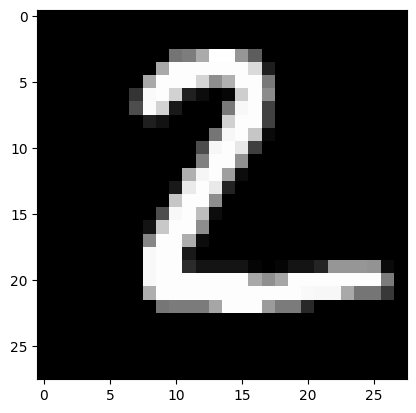

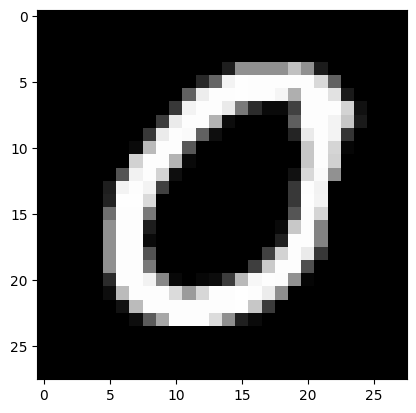

In [29]:
a = dataloader_wrapped.test_loader
b = dataloader_wrapped.train_loader

#check if the content of the two loaders are the same, and print the respective mnist images, use zip
for i, (data_a, data_b) in enumerate(zip(a, b)):
        plt.imshow(data_a[0][0].reshape([28,28]), cmap='gray')
        plt.show()
        plt.imshow(data_b[0][0].reshape([28,28]), cmap='gray')
        plt.show()
        break

In [30]:
params = {
      'depth': 2,
      'width': 1,
      'hidden_dim_lin': 128,
      'activation_function': nn.ReLU,
      'kernel_size': 5,
      'device': device,
      'lr': 0.001,
      'num_train': 20,
      'early_stop_patience': 6,
      'save_best': True,
      'save_checkpoints': True,
      'is_cnn': True,
      'is_debug': True,
      'classification_report_flag': False
    }

# Create DNN model
model = generate_cnn(input_dim = 28, output_dim = 10, depth = params['depth'], num_channels = params['width'],
                     hidden_dim_lin = params['hidden_dim_lin'], kernel_size = params['kernel_size'], activation_function = params["activation_function"], use_pooling=False)
model.to(device)

CustomCNN(
  (conv0): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (fc_1): Linear(in_features=576, out_features=128, bias=True)
  (fc_2): Linear(in_features=128, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
)

In [31]:
model

CustomCNN(
  (conv0): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (fc_1): Linear(in_features=576, out_features=128, bias=True)
  (fc_2): Linear(in_features=128, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
)

In [32]:
# Train and evaluate
trainer = Trainer(model, dataloader_wrapped, params)
train_acc, test_acc, effective_epochs, checkpoints = trainer.train()

print(f"Final Training Accuracy: {train_acc:.4f}")
print(f"Final Test Accuracy: {test_acc:.4f}")

Batch: 0, Loss: 2.3219573497772217
Batch: 20, Loss: 1.287878394126892
Batch: 40, Loss: 0.43129879236221313
Batch: 60, Loss: 0.190947026014328
Batch: 80, Loss: 0.2724006474018097
Batch: 100, Loss: 0.09783657640218735
Batch: 120, Loss: 0.12667039036750793
Batch: 140, Loss: 0.10790370404720306
Batch: 160, Loss: 0.17736266553401947
Batch: 180, Loss: 0.20533007383346558
Batch: 200, Loss: 0.1855286955833435

Average loss: 0.1420, Accuracy: 26352.0/27537 (96%)


Average loss: 0.1670, Accuracy: 2900.0/3059 (95%)

Epoch: 0 	Training Accuracy: 95.70%
Validation Accuracy: 94.80%
Batch: 0, Loss: 0.1347295194864273
Batch: 20, Loss: 0.09360337257385254
Batch: 40, Loss: 0.11007742583751678
Batch: 60, Loss: 0.20858410000801086
Batch: 80, Loss: 0.15436355769634247
Batch: 100, Loss: 0.1163041964173317
Batch: 120, Loss: 0.15751662850379944
Batch: 140, Loss: 0.10946296900510788
Batch: 160, Loss: 0.11063562333583832
Batch: 180, Loss: 0.11089970171451569
Batch: 200, Loss: 0.08668238669633865

Average loss: 

In [33]:
accuracy = eval(model, device, dataloader_wrapped.test_loader, debug = params["is_debug"], is_cnn = params["is_cnn"], classification_report_flag = params["classification_report_flag"])


Average loss: 0.0866, Accuracy: 5010.0/5139 (97%)



conv0.weight: 3.8875
conv1.weight: 3.9582
fc_1.weight: 97.2927
fc_2.weight: 9.4978


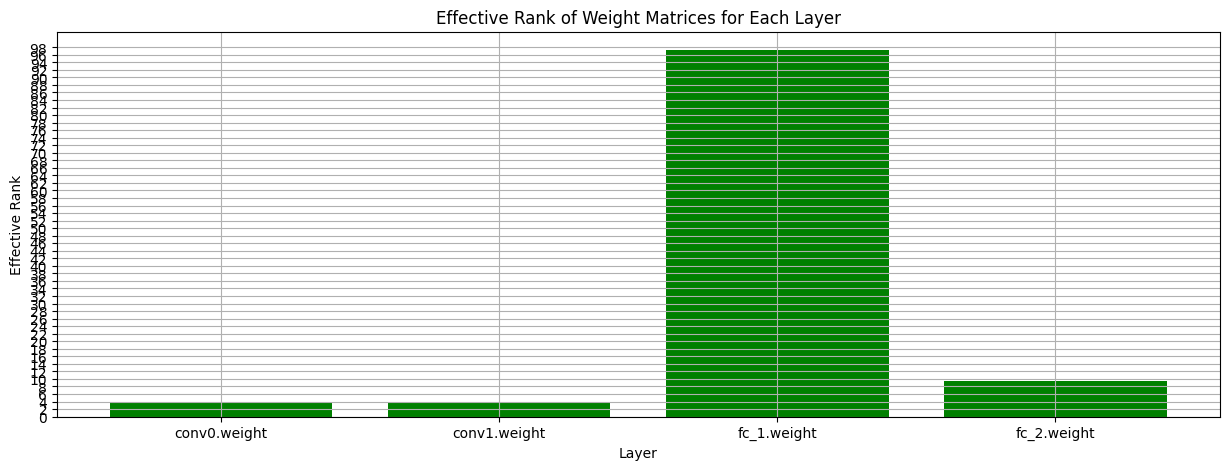

In [34]:
def effective_rank(singular_values):
    normalized_singular_values = singular_values / np.sum(singular_values)
    entropy = -np.sum(normalized_singular_values * np.log(normalized_singular_values))
    eff_rank = np.exp(entropy)
    return eff_rank

def plot_layer_effective_ranks(model, print_ranks=True):
    effective_ranks = []
    layer_names = []

    for name, param in model.named_parameters():
        if 'weight' in name:  # We are only interested in weight matrices
            weight_matrix = param.detach().cpu().numpy()
            singular_values = np.linalg.svd(weight_matrix, compute_uv=False)
            eff_rank = effective_rank(singular_values)
            effective_ranks.append(eff_rank)
            layer_names.append(name)

    if print_ranks:
        for layer_name, eff_rank in zip(layer_names, effective_ranks):
            print(f'{layer_name}: {eff_rank:.4f}')

    # Plotting
    plt.figure(figsize=(15, 5))
    plt.bar(layer_names, effective_ranks, color='green')
    plt.xlabel('Layer')
    plt.ylabel('Effective Rank')
    plt.title('Effective Rank of Weight Matrices for Each Layer')
    plt.grid(True)

    y_max = np.max(effective_ranks) + 1  # Get maximum rank and add 1 for better visualization
    y_min = np.min(effective_ranks) - 1  # Get minimum rank and subtract 1 for better visualization
    plt.yticks(np.arange(0, int(y_max)+2, step=2))  # Set yticks

    plt.show()

# Example usage
plot_layer_effective_ranks(model)  # Note: You'll need to define or load 'model' before calling this function


----

# Finetuning experiments

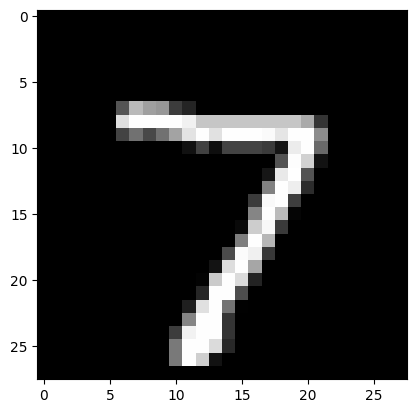

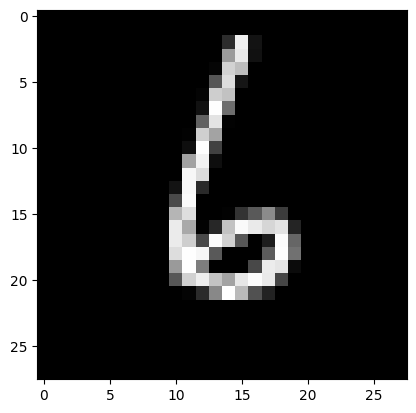

-------------


In [35]:
dataloader_wrapped.update_phase('finetune')

a = dataloader_wrapped.test_loader
b = dataloader_wrapped.train_loader

#check if the content of the two loaders are the same, and print the respective mnist images, use zip
for i, (data_a, data_b) in enumerate(zip(a, b)):
        plt.imshow(data_a[0][0].reshape([28,28]), cmap='gray')
        plt.show()
        plt.imshow(data_b[0][0].reshape([28,28]), cmap='gray')
        plt.show()
        print('-------------')
        break


## Baseline model: end2end with the same architecture as the preatining model

In [36]:
# 2. Create a new model and copy weights from the original model, then adjust the final layer
print("Current dataloader phase: ", dataloader_wrapped.get_current_phase())

model_finetuning_baseline = generate_cnn(input_dim = 28, output_dim = 5, depth = params['depth'], num_channels = params['width'],
                     hidden_dim_lin = params['hidden_dim_lin'], kernel_size = params['kernel_size'], activation_function = params["activation_function"], use_pooling=False)
model_finetuning_baseline.to(device)

# dataloader_wrapped.update_phase('finetune')
# Train and evaluate the new model on the new data
# train_acc_new, test_acc_new, model_finetuning_baseline, _,_ = compute_training_acc_epochs_cnn(model_finetuning_baseline, dataloader_wrapped, params, debug=True)

trainer = Trainer(model, dataloader_wrapped, params)
train_acc_new, test_acc_new, effective_epochs, checkpoints = trainer.train()

print(f"Final Training Accuracy (New Data): {train_acc_new:.4f}")
print(f"Final Test Accuracy (New Data): {test_acc_new:.4f}")

Current dataloader phase:  finetune
Batch: 0, Loss: 4.584918975830078
Batch: 20, Loss: 1.3195247650146484
Batch: 40, Loss: 0.9921354651451111
Batch: 60, Loss: 0.7039961218833923
Batch: 80, Loss: 0.6020423769950867
Batch: 100, Loss: 0.4417096674442291
Batch: 120, Loss: 0.3949466943740845
Batch: 140, Loss: 0.3588717579841614
Batch: 160, Loss: 0.2161933332681656
Batch: 180, Loss: 0.2533576190471649
Batch: 200, Loss: 0.22301582992076874

Average loss: 0.2657, Accuracy: 24166.0/26464 (91%)


Average loss: 0.2850, Accuracy: 2671.0/2940 (91%)

Epoch: 0 	Training Accuracy: 91.32%
Validation Accuracy: 90.85%
Batch: 0, Loss: 0.29162442684173584
Batch: 20, Loss: 0.2400335818529129
Batch: 40, Loss: 0.2543697953224182
Batch: 60, Loss: 0.27579647302627563
Batch: 80, Loss: 0.27850306034088135
Batch: 100, Loss: 0.20663395524024963
Batch: 120, Loss: 0.13089729845523834
Batch: 140, Loss: 0.14954610168933868
Batch: 160, Loss: 0.19710581004619598
Batch: 180, Loss: 0.1306239813566208
Batch: 200, Loss: 0.20

conv0.weight: 4.5751
conv1.weight: 4.2635
fc_1.weight: 124.1947
fc_2.weight: 4.9832


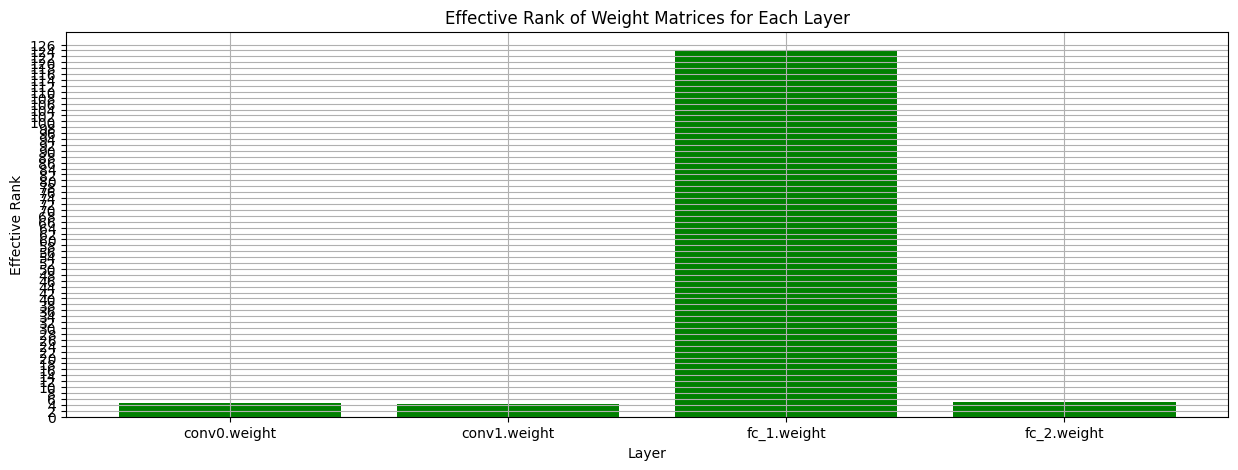

In [37]:
plot_layer_effective_ranks(model_finetuning_baseline)

***WITH BALANCED CLASSES***

Training with different data percentages:   0%|          | 0/10 [00:00<?, ?it/s]

Training for data percentage: 0.01:   0%|          | 0/5 [00:00<?, ?it/s]

Repeat: CustomCNN(
  (conv0): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (fc_1): Linear(in_features=576, out_features=128, bias=True)
  (fc_2): Linear(in_features=128, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
), with seed 20 =========================
Batch: 0, Loss: 1.6081303358078003

Average loss: 1.6128, Accuracy: 52.0/260 (20%)


Average loss: 1.6099, Accuracy: 655.0/2940 (22%)

Epoch: 0 	Training Accuracy: 20.00%
Validation Accuracy: 22.28%
Batch: 0, Loss: 1.6132346391677856

Average loss: 1.6365, Accuracy: 52.0/260 (20%)


Average loss: 1.6360, Accuracy: 551.0/2940 (19%)

Epoch: 1 	Training Accuracy: 20.00%
Validation Accuracy: 18.74%
Batch: 0, Loss: 1.64191734790802

Average loss: 1.6150, Accuracy: 52.0/260 (20%)


Average loss: 1.6183, Accuracy: 551.0/2940 (19%)

Epoch: 2 	Training Accuracy: 20.00%
Validation Accuracy: 18.74%
B

Training for data percentage: 0.03:   0%|          | 0/5 [00:00<?, ?it/s]

Repeat: CustomCNN(
  (conv0): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (fc_1): Linear(in_features=576, out_features=128, bias=True)
  (fc_2): Linear(in_features=128, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
), with seed 76 =========================
Batch: 0, Loss: 1.605858325958252

Average loss: 1.5699, Accuracy: 466.0/790 (59%)


Average loss: 1.5733, Accuracy: 1696.0/2940 (58%)

Epoch: 0 	Training Accuracy: 58.99%
Validation Accuracy: 57.69%
Batch: 0, Loss: 1.5708907842636108

Average loss: 1.4672, Accuracy: 596.0/790 (75%)


Average loss: 1.4756, Accuracy: 2151.0/2940 (73%)

Epoch: 1 	Training Accuracy: 75.44%
Validation Accuracy: 73.16%
Batch: 0, Loss: 1.4625141620635986

Average loss: 1.2580, Accuracy: 623.0/790 (79%)


Average loss: 1.2703, Accuracy: 2280.0/2940 (78%)

Epoch: 2 	Training Accuracy: 78.86%
Validation Accuracy: 7

Training for data percentage: 0.05:   0%|          | 0/5 [00:00<?, ?it/s]

Repeat: CustomCNN(
  (conv0): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (fc_1): Linear(in_features=576, out_features=128, bias=True)
  (fc_2): Linear(in_features=128, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
), with seed 1 =========================
Batch: 0, Loss: 1.6112076044082642

Average loss: 1.5852, Accuracy: 473.0/1320 (36%)


Average loss: 1.5855, Accuracy: 1084.0/2940 (37%)

Epoch: 0 	Training Accuracy: 35.83%
Validation Accuracy: 36.87%
Batch: 0, Loss: 1.5849957466125488

Average loss: 1.4650, Accuracy: 830.0/1320 (63%)


Average loss: 1.4733, Accuracy: 1760.0/2940 (60%)

Epoch: 1 	Training Accuracy: 62.88%
Validation Accuracy: 59.86%
Batch: 0, Loss: 1.4820582866668701

Average loss: 1.0946, Accuracy: 930.0/1320 (70%)


Average loss: 1.1125, Accuracy: 2048.0/2940 (70%)

Epoch: 2 	Training Accuracy: 70.45%
Validation Accuracy

Training for data percentage: 0.1:   0%|          | 0/5 [00:00<?, ?it/s]

Repeat: CustomCNN(
  (conv0): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (fc_1): Linear(in_features=576, out_features=128, bias=True)
  (fc_2): Linear(in_features=128, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
), with seed 86 =========================
Batch: 0, Loss: 1.609818935394287
Batch: 20, Loss: 1.5570757389068604

Average loss: 1.5399, Accuracy: 1327.0/2645 (50%)


Average loss: 1.5418, Accuracy: 1461.0/2940 (50%)

Epoch: 0 	Training Accuracy: 50.17%
Validation Accuracy: 49.69%
Batch: 0, Loss: 1.5359128713607788
Batch: 20, Loss: 1.290062665939331

Average loss: 1.2239, Accuracy: 1728.0/2645 (65%)


Average loss: 1.2337, Accuracy: 1869.0/2940 (64%)

Epoch: 1 	Training Accuracy: 65.33%
Validation Accuracy: 63.57%
Batch: 0, Loss: 1.2368338108062744
Batch: 20, Loss: 0.7132897973060608

Average loss: 0.7650, Accuracy: 1990.0/2645 (75%

Training for data percentage: 0.15:   0%|          | 0/5 [00:00<?, ?it/s]

Repeat: CustomCNN(
  (conv0): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (fc_1): Linear(in_features=576, out_features=128, bias=True)
  (fc_2): Linear(in_features=128, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
), with seed 91 =========================
Batch: 0, Loss: 1.6063824892044067
Batch: 20, Loss: 1.5228055715560913

Average loss: 1.3001, Accuracy: 2447.0/3965 (62%)


Average loss: 1.2908, Accuracy: 1825.0/2940 (62%)

Epoch: 0 	Training Accuracy: 61.72%
Validation Accuracy: 62.07%
Batch: 0, Loss: 1.301032304763794
Batch: 20, Loss: 0.8495128750801086

Average loss: 0.6526, Accuracy: 3095.0/3965 (78%)


Average loss: 0.6463, Accuracy: 2258.0/2940 (77%)

Epoch: 1 	Training Accuracy: 78.06%
Validation Accuracy: 76.80%
Batch: 0, Loss: 0.5732172131538391
Batch: 20, Loss: 0.5191249251365662

Average loss: 0.4155, Accuracy: 3398.0/3965 (86

Training for data percentage: 0.2:   0%|          | 0/5 [00:00<?, ?it/s]

Repeat: CustomCNN(
  (conv0): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (fc_1): Linear(in_features=576, out_features=128, bias=True)
  (fc_2): Linear(in_features=128, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
), with seed 66 =========================
Batch: 0, Loss: 1.6132155656814575
Batch: 20, Loss: 1.5719804763793945
Batch: 40, Loss: 1.2742270231246948

Average loss: 1.2135, Accuracy: 3023.0/5290 (57%)


Average loss: 1.2208, Accuracy: 1747.0/2940 (59%)

Epoch: 0 	Training Accuracy: 57.15%
Validation Accuracy: 59.42%
Batch: 0, Loss: 1.2956560850143433
Batch: 20, Loss: 0.8616040349006653
Batch: 40, Loss: 0.47434380650520325

Average loss: 0.4660, Accuracy: 4458.0/5290 (84%)


Average loss: 0.4805, Accuracy: 2460.0/2940 (84%)

Epoch: 1 	Training Accuracy: 84.27%
Validation Accuracy: 83.67%
Batch: 0, Loss: 0.5604044198989868
Batch: 20,

Training for data percentage: 0.4:   0%|          | 0/5 [00:00<?, ?it/s]

Repeat: CustomCNN(
  (conv0): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (fc_1): Linear(in_features=576, out_features=128, bias=True)
  (fc_2): Linear(in_features=128, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
), with seed 56 =========================
Batch: 0, Loss: 1.6071879863739014
Batch: 20, Loss: 1.3618180751800537
Batch: 40, Loss: 0.3656996786594391
Batch: 60, Loss: 0.3717978596687317
Batch: 80, Loss: 0.26471176743507385

Average loss: 0.3113, Accuracy: 9431.0/10585 (89%)


Average loss: 0.3179, Accuracy: 2596.0/2940 (88%)

Epoch: 0 	Training Accuracy: 89.10%
Validation Accuracy: 88.30%
Batch: 0, Loss: 0.29884016513824463
Batch: 20, Loss: 0.31878626346588135
Batch: 40, Loss: 0.33798080682754517
Batch: 60, Loss: 0.3125153183937073
Batch: 80, Loss: 0.2697353661060333

Average loss: 0.2442, Accuracy: 9706.0/10585 (92%)


Average los

Training for data percentage: 0.6:   0%|          | 0/5 [00:00<?, ?it/s]

Repeat: CustomCNN(
  (conv0): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (fc_1): Linear(in_features=576, out_features=128, bias=True)
  (fc_2): Linear(in_features=128, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
), with seed 2 =========================
Batch: 0, Loss: 1.6176422834396362
Batch: 20, Loss: 1.6096746921539307
Batch: 40, Loss: 1.6115710735321045
Batch: 60, Loss: 1.6083498001098633
Batch: 80, Loss: 1.611161470413208
Batch: 100, Loss: 1.608372688293457
Batch: 120, Loss: 1.6087526082992554

Average loss: 1.6096, Accuracy: 3175.0/15875 (20%)


Average loss: 1.6098, Accuracy: 550.0/2940 (19%)

Epoch: 0 	Training Accuracy: 20.00%
Validation Accuracy: 18.71%
Batch: 0, Loss: 1.6118714809417725
Batch: 20, Loss: 1.609633445739746
Batch: 40, Loss: 1.6096105575561523
Batch: 60, Loss: 1.6087244749069214
Batch: 80, Loss: 1.6113933324813843


Training for data percentage: 0.8:   0%|          | 0/5 [00:00<?, ?it/s]

Repeat: CustomCNN(
  (conv0): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (fc_1): Linear(in_features=576, out_features=128, bias=True)
  (fc_2): Linear(in_features=128, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
), with seed 26 =========================
Batch: 0, Loss: 1.5993552207946777
Batch: 20, Loss: 0.8598342537879944
Batch: 40, Loss: 0.4678419232368469
Batch: 60, Loss: 0.43072691559791565
Batch: 80, Loss: 0.21664959192276
Batch: 100, Loss: 0.29548031091690063
Batch: 120, Loss: 0.19974814355373383
Batch: 140, Loss: 0.2405548244714737
Batch: 160, Loss: 0.13808487355709076

Average loss: 0.2669, Accuracy: 19208.0/21170 (91%)


Average loss: 0.2932, Accuracy: 2644.0/2940 (90%)

Epoch: 0 	Training Accuracy: 90.73%
Validation Accuracy: 89.93%
Batch: 0, Loss: 0.24699924886226654
Batch: 20, Loss: 0.3663277328014374
Batch: 40, Loss: 0.234905

Training for data percentage: 1:   0%|          | 0/5 [00:00<?, ?it/s]

Repeat: CustomCNN(
  (conv0): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (fc_1): Linear(in_features=576, out_features=128, bias=True)
  (fc_2): Linear(in_features=128, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
), with seed 53 =========================
Batch: 0, Loss: 1.6096854209899902
Batch: 20, Loss: 1.2854499816894531
Batch: 40, Loss: 0.5430603623390198
Batch: 60, Loss: 0.29444608092308044
Batch: 80, Loss: 0.33754682540893555
Batch: 100, Loss: 0.3760572075843811
Batch: 120, Loss: 0.31502658128738403
Batch: 140, Loss: 0.24058179557323456
Batch: 160, Loss: 0.20197434723377228
Batch: 180, Loss: 0.1430463194847107
Batch: 200, Loss: 0.3002732992172241

Average loss: 0.1694, Accuracy: 24634.0/26038 (95%)


Average loss: 0.1925, Accuracy: 2769.0/2940 (94%)

Epoch: 0 	Training Accuracy: 94.61%
Validation Accuracy: 94.18%
Batch: 0, Loss: 0.18

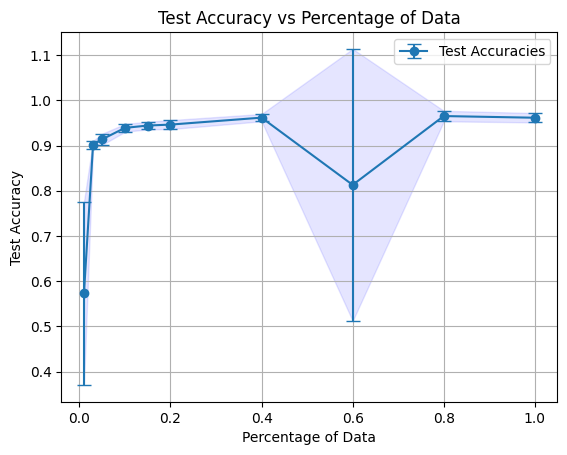

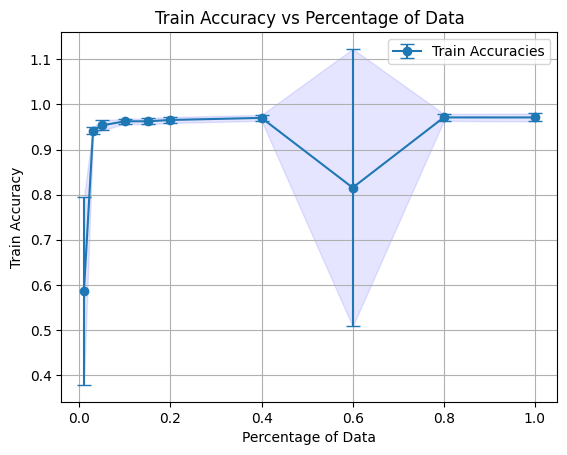

In [38]:
dataloader_wrapped.update_phase('finetune')

percentages = [0.01]
percentages = [0.01, 0.03, 0.05, 0.1, 0.15, 0.2, 0.4, 0.6, 0.8, 1]

seed_set = [10, 20, 30, 40, 50]
repeats = 1

params['lr'] = 0.001
params['num_train'] = 20
params['early_stop_patience'] = 6

# Store results for each percentage
results_test = {}
results_train = {}
best_models = {}
data_loaders = {}
epochs_taken = {}  # Dictionary to store the number of epochs for each (perc, seed) tuple

for perc in tqdm(percentages, desc='Training with different data percentages'):
    test_accuracies = []
    train_accuracies = []
    epochs_for_this_percentage = []

    for seed in tqdm(seed_set, desc=f'Training for data percentage: {perc}', leave=False):
        #temp_seed as a random seed
        temp_seed  = random.randint(0, 100)
        print(f"Repeat: {_}, with seed {temp_seed} =========================")
        
        model_new =  generate_cnn(input_dim = 28, output_dim = 5, depth = params['depth'], num_channels = params['width'],
                     hidden_dim_lin = params['hidden_dim_lin'], kernel_size = params['kernel_size'], activation_function = params["activation_function"], use_pooling=False)
        model_new.to(device)

        # Reduce datasets
        train_loader_transfer_reduced = reduce_dataset(dataloader_wrapped.train_loader, perc, balanced = True, seed=temp_seed)

        if _ == 0:
            data_loaders[perc] = train_loader_transfer_reduced
        test_loader_transfer_reduced = dataloader_wrapped.test_loader
        val_loader_transfer_reduced = dataloader_wrapped.val_loader

        dataset_namespace_new = SimpleNamespace(train_loader=train_loader_transfer_reduced, test_loader=test_loader_transfer_reduced, val_loader=val_loader_transfer_reduced)

        # Train and evaluate the new model on the new data
        trainer = Trainer(model_new, dataset_namespace_new, params)
        train_acc_new, test_acc_new, effective_epochs, checkpoints = trainer.train()

        # Add tqdm write method to prevent progress bar overlap
        tqdm.write(f"Final Training Accuracy (New Data): {train_acc_new:.4f}")
        tqdm.write(f"Final Test Accuracy (New Data): {test_acc_new:.4f}")

        test_accuracies.append(test_acc_new)
        train_accuracies.append(train_acc_new)
        epochs_for_this_percentage.append(effective_epochs)

#         print('eval on reduced train set')
#         accuracy = eval(model_new, device, train_loader_transfer_reduced, debug = params["is_debug"], is_cnn = params["is_cnn"], classification_report_flag = params["classification_report_flag"])
        
#         print('eval on full test set')
#         accuracy = eval(model_new, device, test_loader_transfer_reduced, debug = params["is_debug"], is_cnn = params["is_cnn"], classification_report_flag = params["classification_report_flag"])

    results_test[perc] = test_accuracies
    results_train[perc] = train_accuracies
    epochs_taken[perc] = epochs_for_this_percentage

# Now, you can print or store the number of epochs for each (percentage, seed) tuple:
for perc in percentages:
    for seed, epoch_num in zip(seed_set, epochs_taken[perc]):
        print(f"Percentage: {perc}, Seed: {seed}, Epochs taken: {epoch_num}")

# Plot the results
means = [np.mean(results_test[perc]) for perc in percentages]
stds = [np.std(results_test[perc]) for perc in percentages]
plt.errorbar(percentages, means, yerr=stds, fmt='-o', capsize=5, label="Test Accuracies")
plt.fill_between(percentages, np.subtract(means, stds), np.add(means, stds), color='b', alpha=0.1)

plt.xlabel("Percentage of Data")
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy vs Percentage of Data")
plt.legend()
plt.grid(True)
plt.show()

#plot the training accuracies
means = [np.mean(results_train[perc]) for perc in percentages]
stds = [np.std(results_train[perc]) for perc in percentages]
plt.errorbar(percentages, means, yerr=stds, fmt='-o', capsize=5, label="Train Accuracies")
plt.fill_between(percentages, np.subtract(means, stds), np.add(means, stds), color='b', alpha=0.1)

plt.xlabel("Percentage of Data")
plt.ylabel("Train Accuracy")
plt.title("Train Accuracy vs Percentage of Data")
plt.legend()
plt.grid(True)
plt.show()

## Only heads and data for new classes

now with balanced classes

Processing percentages:   0%|          | 0/10 [00:00<?, ?it/s]

Running seeds for 0.01 data:   0%|          | 0/5 [00:00<?, ?it/s]

Repeat: CustomCNN(
  (conv0): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (fc_1): Linear(in_features=576, out_features=128, bias=True)
  (fc_2): Linear(in_features=128, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
), with seed 79 =========================
Batch: 0, Loss: 1.6109973192214966

Average loss: 1.5885, Accuracy: 103.0/260 (40%)


Average loss: 1.5917, Accuracy: 1041.0/2940 (35%)

Epoch: 0 	Training Accuracy: 39.62%
Validation Accuracy: 35.41%
Batch: 0, Loss: 1.5875240564346313

Average loss: 1.5740, Accuracy: 114.0/260 (44%)


Average loss: 1.5792, Accuracy: 1183.0/2940 (40%)

Epoch: 1 	Training Accuracy: 43.85%
Validation Accuracy: 40.24%
Batch: 0, Loss: 1.5733520984649658

Average loss: 1.5607, Accuracy: 117.0/260 (45%)


Average loss: 1.5675, Accuracy: 1181.0/2940 (40%)

Epoch: 2 	Training Accuracy: 45.00%
Validation Accuracy: 

Running seeds for 0.03 data:   0%|          | 0/5 [00:00<?, ?it/s]

Repeat: CustomCNN(
  (conv0): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (fc_1): Linear(in_features=576, out_features=128, bias=True)
  (fc_2): Linear(in_features=128, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
), with seed 75 =========================
Batch: 0, Loss: 1.6185619831085205

Average loss: 1.5650, Accuracy: 387.0/790 (49%)


Average loss: 1.5670, Accuracy: 1390.0/2940 (47%)

Epoch: 0 	Training Accuracy: 48.99%
Validation Accuracy: 47.28%
Batch: 0, Loss: 1.5671781301498413

Average loss: 1.5150, Accuracy: 573.0/790 (73%)


Average loss: 1.5176, Accuracy: 2069.0/2940 (70%)

Epoch: 1 	Training Accuracy: 72.53%
Validation Accuracy: 70.37%
Batch: 0, Loss: 1.5095911026000977

Average loss: 1.4627, Accuracy: 597.0/790 (76%)


Average loss: 1.4639, Accuracy: 2170.0/2940 (74%)

Epoch: 2 	Training Accuracy: 75.57%
Validation Accuracy: 

Running seeds for 0.05 data:   0%|          | 0/5 [00:00<?, ?it/s]

Repeat: CustomCNN(
  (conv0): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (fc_1): Linear(in_features=576, out_features=128, bias=True)
  (fc_2): Linear(in_features=128, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
), with seed 94 =========================
Batch: 0, Loss: 1.6008843183517456

Average loss: 1.5366, Accuracy: 821.0/1320 (62%)


Average loss: 1.5359, Accuracy: 1796.0/2940 (61%)

Epoch: 0 	Training Accuracy: 62.20%
Validation Accuracy: 61.09%
Batch: 0, Loss: 1.535815715789795

Average loss: 1.4608, Accuracy: 1086.0/1320 (82%)


Average loss: 1.4615, Accuracy: 2353.0/2940 (80%)

Epoch: 1 	Training Accuracy: 82.27%
Validation Accuracy: 80.03%
Batch: 0, Loss: 1.4658429622650146

Average loss: 1.3758, Accuracy: 1133.0/1320 (86%)


Average loss: 1.3780, Accuracy: 2467.0/2940 (84%)

Epoch: 2 	Training Accuracy: 85.83%
Validation Accura

Running seeds for 0.1 data:   0%|          | 0/5 [00:00<?, ?it/s]

Repeat: CustomCNN(
  (conv0): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (fc_1): Linear(in_features=576, out_features=128, bias=True)
  (fc_2): Linear(in_features=128, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
), with seed 28 =========================
Batch: 0, Loss: 1.6208575963974
Batch: 20, Loss: 1.4768792390823364

Average loss: 1.4641, Accuracy: 2093.0/2645 (79%)


Average loss: 1.4631, Accuracy: 2320.0/2940 (79%)

Epoch: 0 	Training Accuracy: 79.13%
Validation Accuracy: 78.91%
Batch: 0, Loss: 1.467968463897705
Batch: 20, Loss: 1.283510684967041

Average loss: 1.2848, Accuracy: 2254.0/2645 (85%)


Average loss: 1.2827, Accuracy: 2483.0/2940 (84%)

Epoch: 1 	Training Accuracy: 85.22%
Validation Accuracy: 84.46%
Batch: 0, Loss: 1.2873536348342896
Batch: 20, Loss: 1.081149697303772

Average loss: 1.0801, Accuracy: 2299.0/2645 (87%)




Running seeds for 0.15 data:   0%|          | 0/5 [00:00<?, ?it/s]

Repeat: CustomCNN(
  (conv0): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (fc_1): Linear(in_features=576, out_features=128, bias=True)
  (fc_2): Linear(in_features=128, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
), with seed 95 =========================
Batch: 0, Loss: 1.6052093505859375
Batch: 20, Loss: 1.468259334564209

Average loss: 1.3773, Accuracy: 3087.0/3965 (78%)


Average loss: 1.3688, Accuracy: 2294.0/2940 (78%)

Epoch: 0 	Training Accuracy: 77.86%
Validation Accuracy: 78.03%
Batch: 0, Loss: 1.3428267240524292
Batch: 20, Loss: 1.2029407024383545

Average loss: 1.0947, Accuracy: 3485.0/3965 (88%)


Average loss: 1.0862, Accuracy: 2580.0/2940 (88%)

Epoch: 1 	Training Accuracy: 87.89%
Validation Accuracy: 87.76%
Batch: 0, Loss: 1.1098744869232178
Batch: 20, Loss: 0.9129390716552734

Average loss: 0.8128, Accuracy: 3518.0/3965 (89

Running seeds for 0.2 data:   0%|          | 0/5 [00:00<?, ?it/s]

Repeat: CustomCNN(
  (conv0): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (fc_1): Linear(in_features=576, out_features=128, bias=True)
  (fc_2): Linear(in_features=128, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
), with seed 38 =========================
Batch: 0, Loss: 1.608364462852478
Batch: 20, Loss: 1.4606420993804932
Batch: 40, Loss: 1.3170512914657593

Average loss: 1.3002, Accuracy: 4413.0/5290 (83%)


Average loss: 1.2980, Accuracy: 2460.0/2940 (84%)

Epoch: 0 	Training Accuracy: 83.42%
Validation Accuracy: 83.67%
Batch: 0, Loss: 1.307158350944519
Batch: 20, Loss: 1.1134765148162842
Batch: 40, Loss: 0.9060041904449463

Average loss: 0.9033, Accuracy: 4765.0/5290 (90%)


Average loss: 0.9058, Accuracy: 2611.0/2940 (89%)

Epoch: 1 	Training Accuracy: 90.08%
Validation Accuracy: 88.81%
Batch: 0, Loss: 0.9326393008232117
Batch: 20, Lo

Running seeds for 0.4 data:   0%|          | 0/5 [00:00<?, ?it/s]

Repeat: CustomCNN(
  (conv0): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (fc_1): Linear(in_features=576, out_features=128, bias=True)
  (fc_2): Linear(in_features=128, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
), with seed 78 =========================
Batch: 0, Loss: 1.624716877937317
Batch: 20, Loss: 1.4620047807693481
Batch: 40, Loss: 1.2849955558776855
Batch: 60, Loss: 1.1129508018493652
Batch: 80, Loss: 0.9385185241699219

Average loss: 0.9029, Accuracy: 9325.0/10585 (88%)


Average loss: 0.8971, Accuracy: 2562.0/2940 (87%)

Epoch: 0 	Training Accuracy: 88.10%
Validation Accuracy: 87.14%
Batch: 0, Loss: 0.8864190578460693
Batch: 20, Loss: 0.7443690896034241
Batch: 40, Loss: 0.6503378748893738
Batch: 60, Loss: 0.5110639333724976
Batch: 80, Loss: 0.4286576509475708

Average loss: 0.4251, Accuracy: 9575.0/10585 (90%)


Average loss: 0.

Running seeds for 0.6 data:   0%|          | 0/5 [00:00<?, ?it/s]

Repeat: CustomCNN(
  (conv0): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (fc_1): Linear(in_features=576, out_features=128, bias=True)
  (fc_2): Linear(in_features=128, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
), with seed 80 =========================
Batch: 0, Loss: 1.614218831062317
Batch: 20, Loss: 1.467597246170044
Batch: 40, Loss: 1.3312673568725586
Batch: 60, Loss: 1.0993722677230835
Batch: 80, Loss: 0.939899742603302
Batch: 100, Loss: 0.7189434766769409
Batch: 120, Loss: 0.6363924741744995

Average loss: 0.5920, Accuracy: 14233.0/15875 (90%)


Average loss: 0.5970, Accuracy: 2618.0/2940 (89%)

Epoch: 0 	Training Accuracy: 89.66%
Validation Accuracy: 89.05%
Batch: 0, Loss: 0.5840966105461121
Batch: 20, Loss: 0.4761204421520233
Batch: 40, Loss: 0.5122534036636353
Batch: 60, Loss: 0.36374545097351074
Batch: 80, Loss: 0.2920164465904

Running seeds for 0.8 data:   0%|          | 0/5 [00:00<?, ?it/s]

Repeat: CustomCNN(
  (conv0): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (fc_1): Linear(in_features=576, out_features=128, bias=True)
  (fc_2): Linear(in_features=128, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
), with seed 2 =========================
Batch: 0, Loss: 1.6121433973312378
Batch: 20, Loss: 1.4799529314041138
Batch: 40, Loss: 1.3459935188293457
Batch: 60, Loss: 1.1557954549789429
Batch: 80, Loss: 0.9682044386863708
Batch: 100, Loss: 0.8055883646011353
Batch: 120, Loss: 0.6852320432662964
Batch: 140, Loss: 0.5695098638534546
Batch: 160, Loss: 0.4006091058254242

Average loss: 0.4205, Accuracy: 19309.0/21170 (91%)


Average loss: 0.4288, Accuracy: 2651.0/2940 (90%)

Epoch: 0 	Training Accuracy: 91.21%
Validation Accuracy: 90.17%
Batch: 0, Loss: 0.4793761670589447
Batch: 20, Loss: 0.35741928219795227
Batch: 40, Loss: 0.353676289

Running seeds for 1 data:   0%|          | 0/5 [00:00<?, ?it/s]

Repeat: CustomCNN(
  (conv0): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act0): ReLU()
  (conv1): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (act1): ReLU()
  (fc_1): Linear(in_features=576, out_features=128, bias=True)
  (fc_2): Linear(in_features=128, out_features=10, bias=True)
  (logsoftmax): LogSoftmax(dim=1)
), with seed 4 =========================
Batch: 0, Loss: 1.6339712142944336
Batch: 20, Loss: 1.5046128034591675
Batch: 40, Loss: 1.3481905460357666
Batch: 60, Loss: 1.1501710414886475
Batch: 80, Loss: 0.9675076603889465
Batch: 100, Loss: 0.8305439949035645
Batch: 120, Loss: 0.5994056463241577
Batch: 140, Loss: 0.5522384643554688
Batch: 160, Loss: 0.44395309686660767
Batch: 180, Loss: 0.3935598134994507
Batch: 200, Loss: 0.28802159428596497

Average loss: 0.3345, Accuracy: 23885.0/26038 (92%)


Average loss: 0.3490, Accuracy: 2668.0/2940 (91%)

Epoch: 0 	Training Accuracy: 91.73%
Validation Accuracy: 90.75%
Batch: 0, Loss: 0.358637

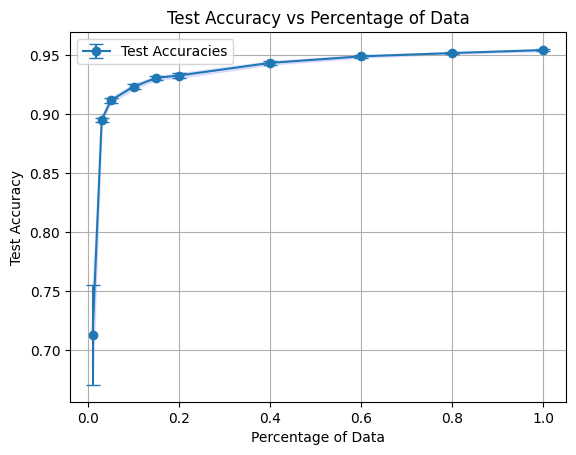

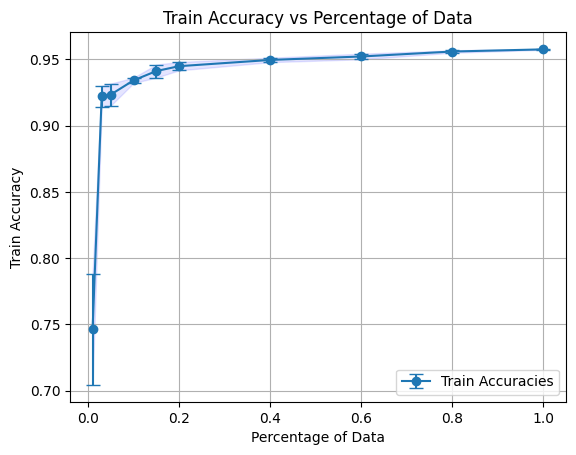

In [40]:
dataloader_wrapped.update_phase('finetune')

percentages = [0.01, 0.03, 0.05, 0.1, 0.15, 0.2, 0.4, 0.6, 0.8, 1]
seed_set = [10, 20, 30, 40, 50]
repeats = 1

params['lr'] = 0.0001
params['num_train'] = 20
params['early_stop_patience'] = 6

# Store results for each percentage
results_test_finetune = {}
results_train_finetune = {}
best_models = {}
data_loaders = {}
epochs_taken_finetune = {}  # Dictionary to store the number of epochs for each (perc, seed) tuple

for perc in tqdm(percentages, desc='Processing percentages'):
    test_accuracies = []
    train_accuracies = []
    epochs_for_this_percentage = []
    
    for seed in tqdm(seed_set, desc=f'Running seeds for {perc} data', leave=False):
        #temp_seed as a random seed
        temp_seed  = random.randint(0, 100)
        print(f"Repeat: {_}, with seed {temp_seed} =========================")

                # Copying model
        model_new = copy.deepcopy(model)

        # Calculate the output size from the pool layer dynamically
        # You would replace this with the actual size based on your model's architecture
        model_new.fc_1 = nn.Linear(576, 128)
    
        # Reinitialize the second fully connected layer
        model_new.fc_2 = nn.Linear(128, 5)
        
        # Ensure the softmax layer matches the number of classes (if used)
        model_new.softmax = nn.Softmax(dim=1)
        
        model_new.to(device)
        
        # Reduce datasets
        train_loader_transfer_reduced = reduce_dataset(dataloader_wrapped.train_loader, perc, balanced = True, seed=temp_seed)
        if _ == 0:
            data_loaders[perc] = train_loader_transfer_reduced
        test_loader_transfer_reduced = dataloader_wrapped.test_loader
        val_loader_transfer_reduced = dataloader_wrapped.val_loader

        dataset_namespace_new = SimpleNamespace(train_loader=train_loader_transfer_reduced, test_loader=test_loader_transfer_reduced, val_loader=val_loader_transfer_reduced)

        trainer = Trainer(model_new, dataset_namespace_new, params)
        train_acc_new, test_acc_new, effective_epochs, checkpoints = trainer.train()

        test_accuracies.append(test_acc_new)
        train_accuracies.append(train_acc_new)
        epochs_for_this_percentage.append(effective_epochs)

#         print('eval on reduced train set')
#         accuracy = eval(model_new, device, train_loader_transfer_reduced, debug = params["is_debug"], is_cnn = params["is_cnn"], classification_report_flag = params["classification_report_flag"])
        
#         print('eval on full test set')
#         accuracy = eval(model_new, device, test_loader_transfer_reduced, debug = params["is_debug"], is_cnn = params["is_cnn"], classification_report_flag = params["classification_report_flag"])

    results_test_finetune[perc] = test_accuracies
    results_train_finetune[perc] = train_accuracies
    epochs_taken_finetune[perc] = epochs_for_this_percentage

# Now, you can print or store the number of epochs for each (percentage, seed) tuple:
for perc in percentages:
    for seed, epoch_num in zip(seed_set, epochs_taken_finetune[perc]):
        print(f"Percentage: {perc}, Seed: {seed}, Epochs taken: {epoch_num}")

# Plot the results
means = [np.mean(results_test_finetune[perc]) for perc in percentages]
stds = [np.std(results_test_finetune[perc]) for perc in percentages]
plt.errorbar(percentages, means, yerr=stds, fmt='-o', capsize=5, label="Test Accuracies")
plt.fill_between(percentages, np.subtract(means, stds), np.add(means, stds), color='b', alpha=0.1)

plt.xlabel("Percentage of Data")
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy vs Percentage of Data")
plt.legend()
plt.grid(True)
plt.show()

#plot the training accuracies
means = [np.mean(results_train_finetune[perc]) for perc in percentages]
stds = [np.std(results_train_finetune[perc]) for perc in percentages]
plt.errorbar(percentages, means, yerr=stds, fmt='-o', capsize=5, label="Train Accuracies")
plt.fill_between(percentages, np.subtract(means, stds), np.add(means, stds), color='b', alpha=0.1)

plt.xlabel("Percentage of Data")
plt.ylabel("Train Accuracy")
plt.title("Train Accuracy vs Percentage of Data")
plt.legend()
plt.grid(True)
plt.show()


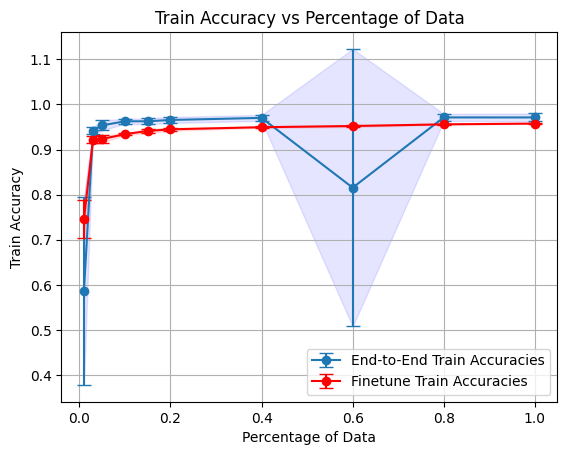

In [41]:
# End to End - Train Accuracies
means = [np.mean(results_train[perc]) for perc in percentages]
stds = [np.std(results_train[perc]) for perc in percentages]
plt.errorbar(percentages, means, yerr=stds, fmt='-o', capsize=5, label="End-to-End Train Accuracies")
plt.fill_between(percentages, np.subtract(means, stds), np.add(means, stds), color='b', alpha=0.1)

# Finetune - Train Accuracies
means = [np.mean(results_train_finetune[perc]) for perc in percentages]
stds = [np.std(results_train_finetune[perc]) for perc in percentages]
plt.errorbar(percentages, means, yerr=stds, fmt='-o', capsize=5, label="Finetune Train Accuracies", color='r')
plt.fill_between(percentages, np.subtract(means, stds), np.add(means, stds), color='r', alpha=0.1)

# Displaying the Train Accuracies plot
plt.xlabel("Percentage of Data")
plt.ylabel("Train Accuracy")
plt.title("Train Accuracy vs Percentage of Data")
plt.legend()
plt.grid(True)
plt.show()

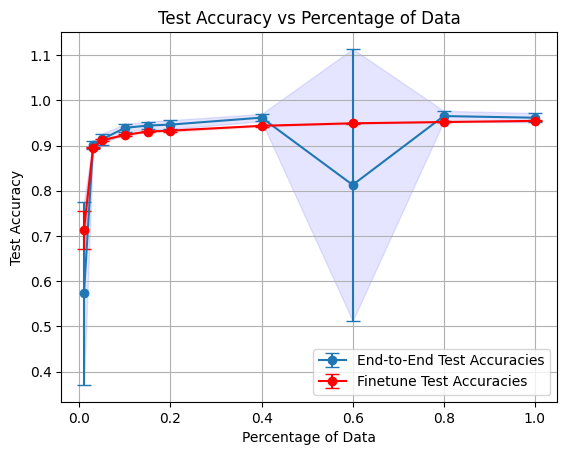

In [42]:
# End to End - Test Accuracies
means = [np.mean(results_test[perc]) for perc in percentages]
stds = [np.std(results_test[perc]) for perc in percentages]

plt.errorbar(percentages, means, yerr=stds, fmt='-o', capsize=5, label="End-to-End Test Accuracies")
plt.fill_between(percentages, np.subtract(means, stds), np.add(means, stds), color='b', alpha=0.1)

# Finetune - Test Accuracies
means = [np.mean(results_test_finetune[perc]) for perc in percentages]
stds = [np.std(results_test_finetune[perc]) for perc in percentages]
plt.errorbar(percentages, means, yerr=stds, fmt='-o', capsize=5, label="Finetune Test Accuracies", color='r')
plt.fill_between(percentages, np.subtract(means, stds), np.add(means, stds), color='r', alpha=0.1)

# Displaying the Test Accuracies plot
plt.xlabel("Percentage of Data")
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy vs Percentage of Data")
plt.legend()
plt.grid(True)
plt.show()

In [43]:
data_to_save = {
    "results_test_finetune": results_test_finetune,
    "results_train_finetune": results_train_finetune,
    "epochs_taken_finetune": epochs_taken_finetune,
    
    "results_test": results_test,
    "results_train": results_train,
    "epochs_taken": epochs_taken
}

# Assuming data_to_save from the previous code
with open("data.json", "w") as file:
    json.dump(data_to_save, file)

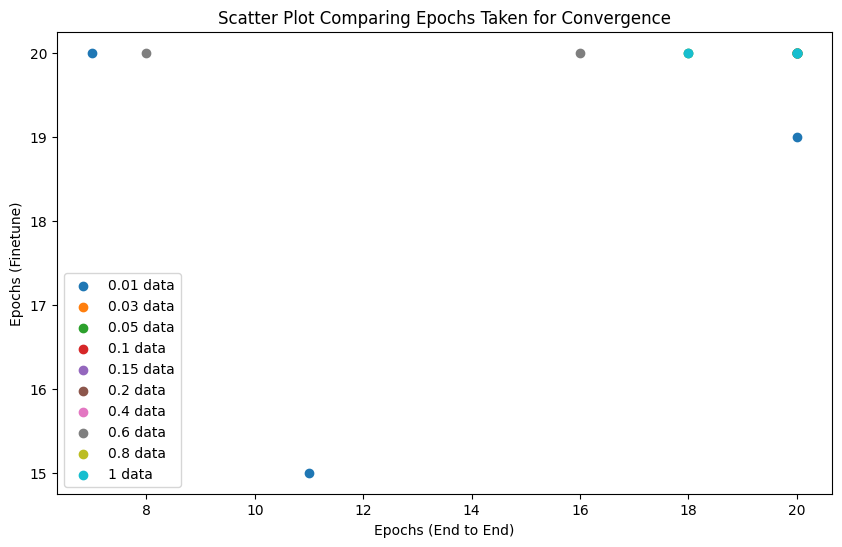

In [44]:
plt.figure(figsize=(10, 6))

for perc in percentages:
    plt.scatter(epochs_taken[perc], epochs_taken_finetune[perc], label=f'{perc} data')
plt.xlabel('Epochs (End to End)')
plt.ylabel('Epochs (Finetune)')
plt.title('Scatter Plot Comparing Epochs Taken for Convergence')
plt.legend()
plt.show()

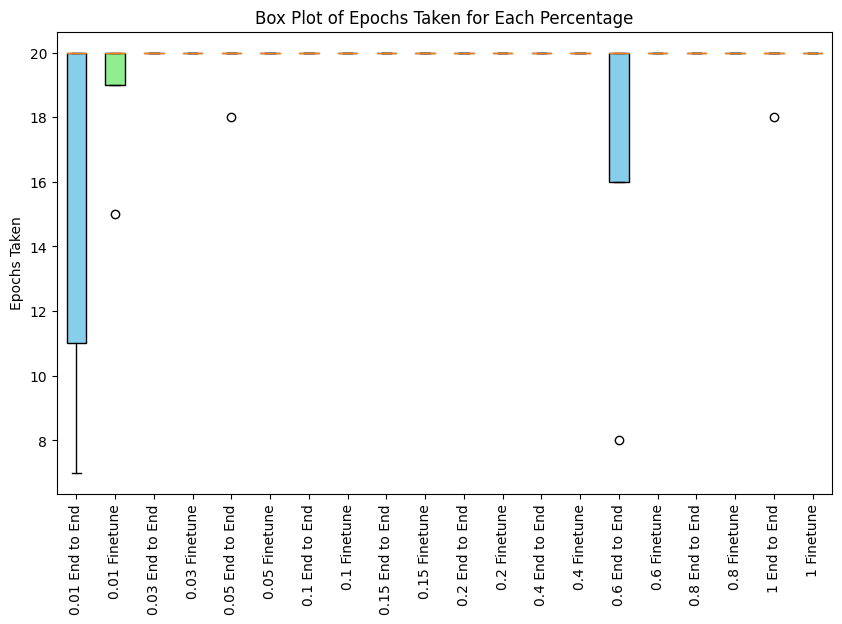

In [45]:
# Given data
percentages = list(epochs_taken.keys())

all_epochs = []
labels = []

for perc in percentages:
    all_epochs.extend([epochs_taken[perc], epochs_taken_finetune[perc]])
    labels.extend([f'{perc} End to End', f'{perc} Finetune'])

# Plotting
plt.figure(figsize=(10, 6))
box = plt.boxplot(all_epochs, labels=labels, patch_artist=True)

# Coloring
colors = ['skyblue', 'lightgreen'] * len(percentages)
for patch, color in zip(box['boxes'], colors):
    patch.set_facecolor(color)

plt.ylabel('Epochs Taken')
plt.title('Box Plot of Epochs Taken for Each Percentage')
plt.xticks(rotation=90)
plt.show()
